# Setting up pymupdf for image extraction

In [1]:
!pip install pymupdf
!pip install groq
!pip install beautifulsoup4
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 1.8 MB/s eta 0:00:00


In [2]:
import fitz
import io
import base64
import tempfile
from bs4 import BeautifulSoup
from IPython.display import Image, display

In [3]:
def convert_pdf_page_to_image(pdf_file_path, output_image_file_name, page_number, zoom=2):
    """
    Saves a specific page of a PDF to an image.

    Args:
    pdf_file_path (str): Path to the PDF file.
    page_number (int): Page number to convert to image (0-based index).
    zoom (float): Zoom factor for the image. Higher values mean better quality.
    output_image_file_name (str): Name of the output image file.
    """
    document = fitz.open(pdf_file_path)
    page = document.load_page(page_number-1)

    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)

    pix.save(output_image_file_name)

    document.close()

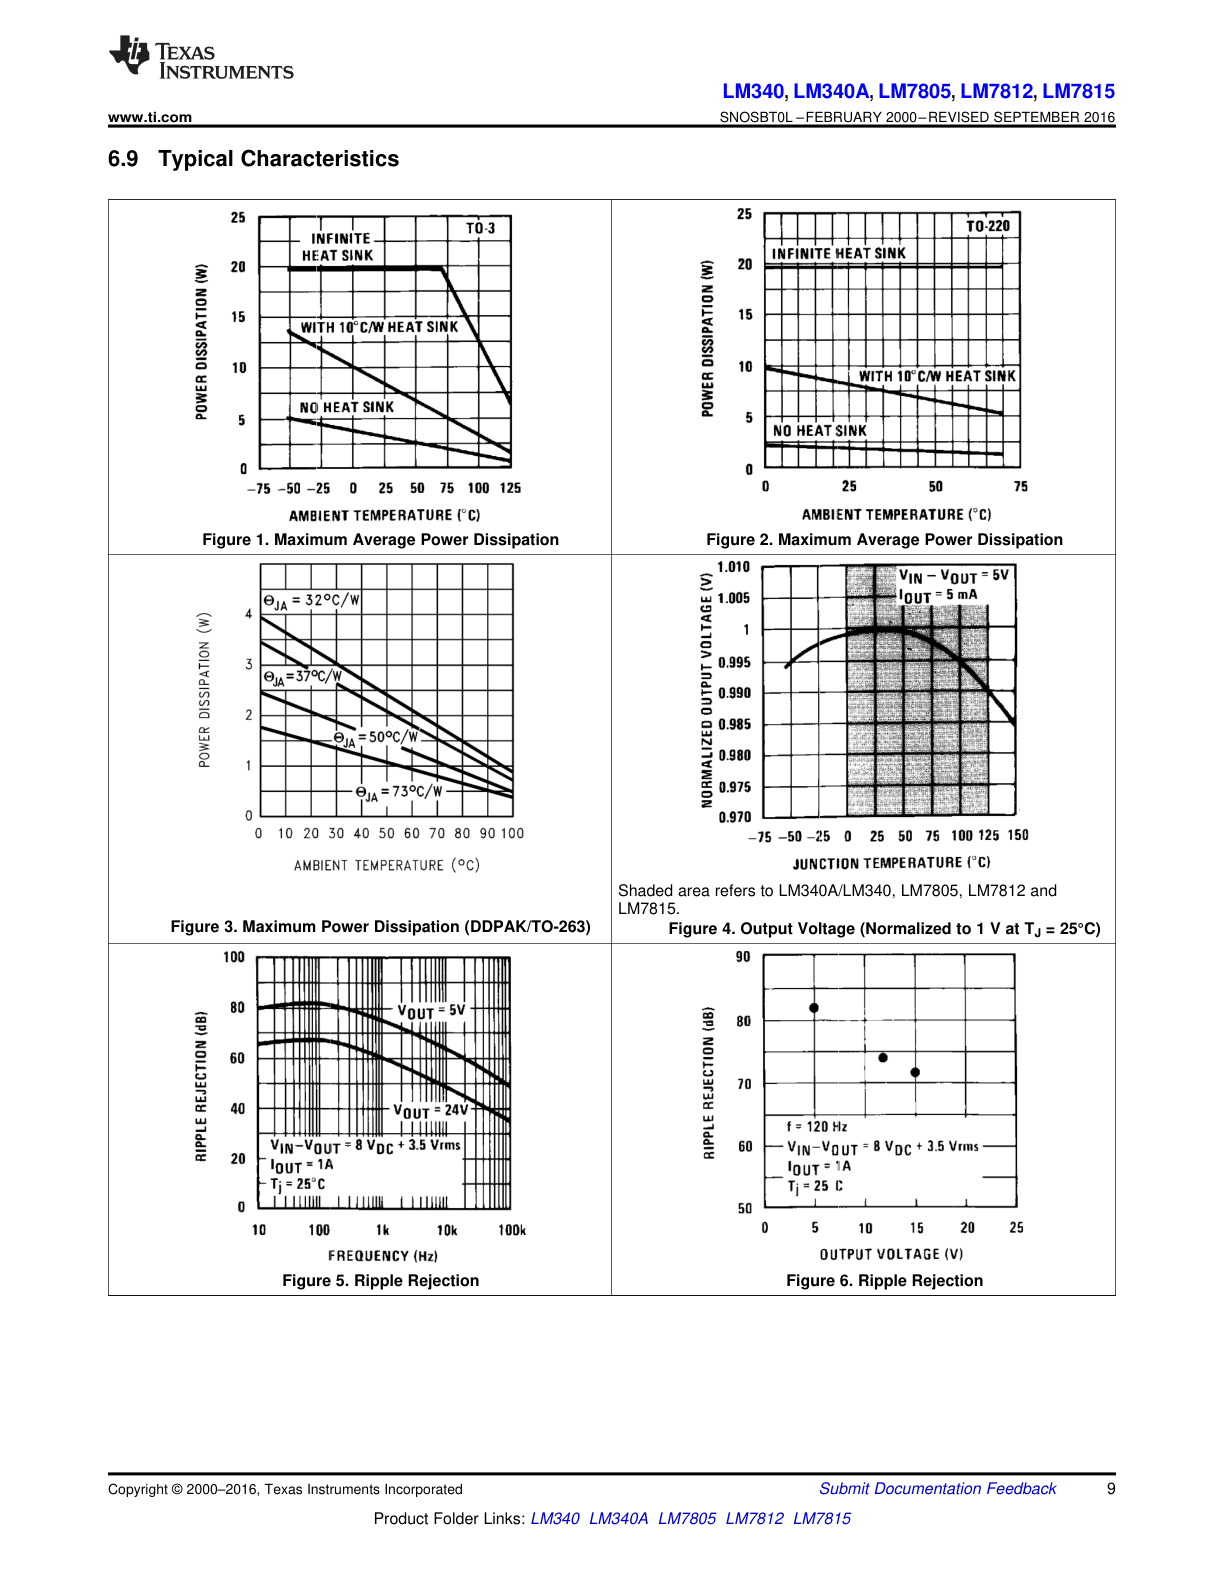

In [26]:
pdf_file_path = "./Week_2/Day_4/Files/lm340.pdf"
output_image_file_path = "./Week_2/Day_4/Files/output_image.png"
page_number = 9  # First page
zoom = 2  # Zoom factor
convert_pdf_page_to_image(pdf_file_path, output_image_file_path, page_number, zoom)
# Display the saved image
display(Image(filename=output_image_file_path))

In [27]:
# Function to encode the image in base64 format
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = output_image_file_path

# Getting the base64 string
base64_image = encode_image(image_path)
print(base64_image)

iVBORw0KGgoAAAANSUhEUgAABMgAAAYwCAIAAAAI8uQFAAAACXBIWXMAAA7EAAAOxAGVKw4bAAT0HElEQVR4nOzdB3QUVR8F8NBEikiTHkrohA4WehFBBAHpTYooSK+CgChFpDelgyBIE5AOUqVL7x8dDL2EHhISQpL97u5/eZnMbjaz2SUh8f7OHs7u2zczb0pm32Wah4mIiIiIiIjIBR6x3QAiIiIiIiKK2xgsiYiIiIiIyCUMlkREREREROQSBksiIiIiIiJyCYMlERERERERuYTBkoiIiIiIiFzCYElEREREREQuYbAkIiIiIiIilzBYEhERERERkUsYLImIiIiIiMglDJZERERERETkEgZLIiIiIiIicgmDJREREREREbmEwZKIiIiIiIhcwmBJRERERERELmGwJCIiIiIiIpcwWBIREREREZFLGCyJiIiIiIjIJQyWRERERERE5BIGSyIiIiIiInIJgyURERERERG5hMGSiIiIiIiIXMJgSURERERERC5hsCQiIiIiIiKXMFgSERERERGRSxgsiYiIiIiIyCUMlkREREREROQSBksiIiIiIiJyCYMlERERERERuYTBkoiIiIiIiFzCYElEREREREQuYbAkIiIiIiIilzBYEhERERERkUsYLImIiIiIiMglDJYx5I8lSwZ8+63dF76K7dYRERERERFFH4NlDOnetatXjhx2X/gqtltHREREREQUfQyWMcR4sAwKClq0cKG8du7YEVsNJiIiIiIiMojBMoYYD5bHjx1TXw3+4YdYai8REREREZFRDJYxxHiwnD9vnvpq+bJlsdVgIiIiIiIigxgsY4jxYNmnd2/11ZnTp2OrwURERERERAYxWMYQ48Hy5IkTe3bvlteLFy9iq8FEREREREQGMVjGEAfBsk2rVictAgMDQ0JCTr7k4+ODAa9du3bSnufPn9udEMqvGhMcHByji4CIiIiIiOIpBssY4iBYqteDBw8uXryoPvbv

# Text extraction Using Groq

In [15]:
from groq import Groq


In [ ]:
# API keys in google colab
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KEY')
openai_api_key = userdata.get('OPENAI_API_KEY')

In [17]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get the HUGGINGFACE_TOKEN
groq_api_key = os.getenv('GROQ_API_KEY')
openai_api_key = os.getenv('OPENAI_API_KEY')

In [18]:
from groq import Groq
client = Groq(api_key=groq_api_key)
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",       # role system currently not supported by groq
            "content": [
                {"type": "text", 
                 "text": "Reproduce the text and tables within this image verbatim in markdown format"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    model="llama-3.2-90b-vision-preview",
)

textInImage = chat_completion.choices[0].message.content

print(textInImage)

The image presents a comprehensive table detailing the electrical characteristics of the LM340, LM340A, LM7805, LM7812, and LM7815 voltage regulators. The table is divided into two main sections: the top section provides an introduction to the document, including the title, "6.5 LM340A Electrical Characteristics," and the voltage range for which the specifications apply (5 V, V in, ± 10 V). Additionally, it includes copyright information from Texas Instruments.
 
 In the introductions is a link that it is unclear whether it serves an information-purposive or reference purpose:
https://www.ti.com/product/LM340

The bottom section of the table is organized into columns representing different parameters or conditions, with rows corresponding to specific values or ranges. The columns are labeled as follows:

• **Parameter**: This column lists the various electrical characteristics being measured or specified, such as output voltage, line regulation, load regulation, quiescent current, and 

In [19]:
from IPython.display import Markdown, display

display(Markdown(textInImage))

The image presents a comprehensive table detailing the electrical characteristics of the LM340, LM340A, LM7805, LM7812, and LM7815 voltage regulators. The table is divided into two main sections: the top section provides an introduction to the document, including the title, "6.5 LM340A Electrical Characteristics," and the voltage range for which the specifications apply (5 V, V in, ± 10 V). Additionally, it includes copyright information from Texas Instruments.
 
 In the introductions is a link that it is unclear whether it serves an information-purposive or reference purpose:
https://www.ti.com/product/LM340

The bottom section of the table is organized into columns representing different parameters or conditions, with rows corresponding to specific values or ranges. The columns are labeled as follows:

• **Parameter**: This column lists the various electrical characteristics being measured or specified, such as output voltage, line regulation, load regulation, quiescent current, and ripple rejection.
• **Test Conditions**: This column describes the conditions under which each parameter is tested or specified, including temperature, input voltage, output current, and other relevant factors.
• **Min**: This column shows the minimum value for each parameter.
• **Typ**: This column displays the typical value for each parameter.
• **Max**: This column indicates the maximum value for each parameter.
• **Unit**: This column specifies the unit of measurement for each parameter.

The table provides a detailed snapshot of the electrical performance of these voltage regulators under various operating conditions. It serves as a valuable reference for engineers and designers who need to select and use these components in their projects.

# Text extraction Using GPT-4o-mini

In [20]:
from openai import OpenAI

In [30]:
client = OpenAI(api_key=openai_api_key)
completion = client.chat.completions.create(
  model= "gpt-4o-mini",
  messages = [
            {
                "role": "system",
                "content": "What is the ripple rejection for the output voltage of 15V?"
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
  max_tokens= 4095
)

textInImage = completion.choices[0].message.content

In [31]:
from IPython.display import Markdown, display

display(Markdown(textInImage))


The ripple rejection for the output voltage of 15V can be found in the provided figure related to ripple rejection characteristics. Since the graph typically plots frequency against ripple rejection, you can estimate the ripple rejection value at the specified output voltage (15V) by locating the corresponding output voltage on the horizontal axis of the graph.

If the graph indicates values for various output voltages, follow these steps:

1. **Locate the 15V mark** on the output voltage axis (X-axis).
2. **Draw a vertical line** upwards to intersect the curve that corresponds to ripple rejection.
3. **Read the corresponding value** on the Y-axis, which reflects the ripple rejection (in dB).

The exact value will depend on the actual graph; please refer to the corresponding figure in your document for precise data.